In [11]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('../../data/ST001937_AN003150.csv')

Dropping not needed columns and renaming the Phenotypes column to labels

In [12]:
df = df.drop(['Sample ID', 'RAW_FILE_NAME'], axis=1)
df['Phenotypes'] = df['Phenotypes'].apply(lambda x: 0 if x == 'Healthy Controls' else 1 if x == 'Maligant SPNS' else 2)

Filling missing values with the mean

In [13]:
df.fillna(df.mean(), inplace=True)

Performing SVM RBF classification and plotting the results

In [14]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

In [15]:

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting the data into features (X) and labels (y)
X = df.drop('Phenotypes', axis=1)
y = df['Phenotypes']

X_2d = X.iloc[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

C_range = np.logspace(-2, 10, 20)
gamma_range = np.logspace(-9, 3, 20)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 3.359818286283781, 'gamma': 0.00206913808111479} with a score of 0.81


In [16]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))


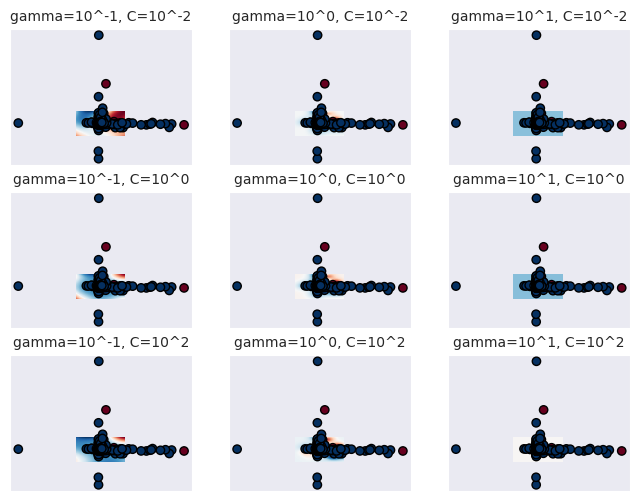

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for k, (C, gamma, clf) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

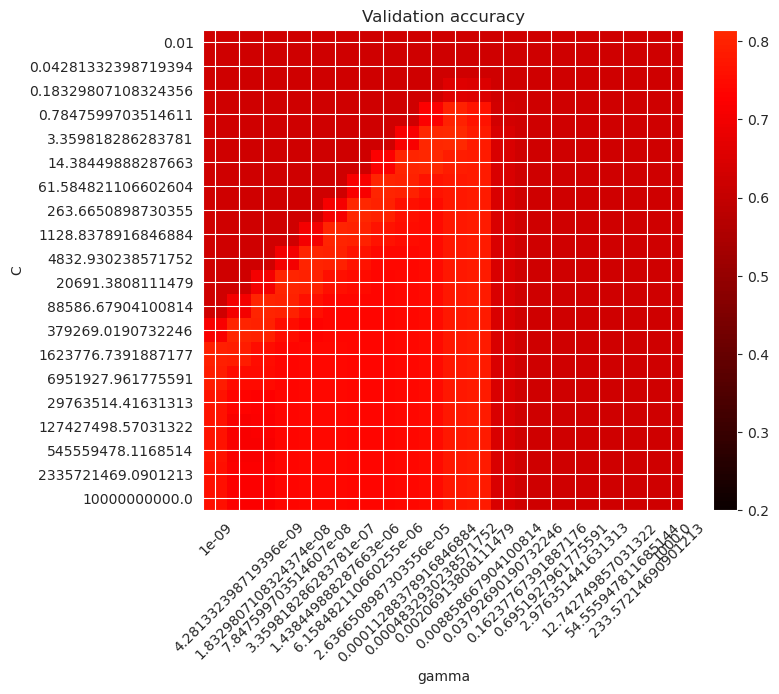

In [18]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()